# <center> Machine Learning For Scientifically Locating <br> The Best Waste Management Plant location for the city of Kochi</center>

___

## <center> Capstone Project Notebook</center>

### Importing necessary packages 

In [1]:
!pip install folium

     |████████████████████████████████| 102kB 7.2MB/s ta 0:00:011


In [2]:
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup as bs
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Introduction 

This study aims at mining the best possible locations for waste treatment plant for the city of Kochi, in the district of Ernakulam, Kerala, southern part of India. Kochi is port city, that significantly contributes to the GDP of the state of Kerala as well as to the country India as a whole. This study will try to use __machine learning and Foursquare API__ to simulate the neighborhood of East Calgary Facility, city of Calgary, Canada - which is considered as one of the cleanest cities of the world.

## Project Methodology

1. Generate East Calgary Facility datapoint -Get East Calgary Facility location data and represent East Calgary landfill with respect to the surrounding venues using Foursquare explore option and generate a dataset
2. Generate Ernakulam neighborhood dataset - This step will help us to represent Ernakulam district in terms of neighborhoods using the dataset generated using Foursquare explore option
3. Prepare the clustering dataset - Calgary and neighborhoods of Ernakulam will have differences in venue categories and hence the datasets must be processed for clustering application
4. Prepare the clustered dataset of Ernakulam - This dataset will have cluster labels attribute to each neighborhood
5. Filter out the neighborhoods similar to East Calgary Facility - this is done using the cluster labels
6. Conclusion - Provide recommendation

## Step- 1. Generate East Calgary Facility Datapoint 

#### Retrieving East Calgary Facility Location data

In [3]:
landfill_address = 'East Calgary Landfill'
geolocator = Nominatim(user_agent = 'my_explorer')
cg_landfill_loc = geolocator.geocode(landfill_address)
cg_lat, cg_long = cg_landfill_loc.latitude, cg_landfill_loc.longitude
cg_lat, cg_long

(51.024618149999995, -113.94053147888758)

#### Visualize East Calgary Facility

In [4]:
cg_landfill_map = folium.Map(location= [cg_lat, cg_long], zoom_start= 12)
folium.CircleMarker(location = [cg_lat, cg_long], 
              radius = 10,
              color = 'blue',
              popup = 'East Calgary Landfill',
             fill_color = 'blue',
             fill_opacity = 0.3).add_to(cg_landfill_map)
cg_landfill_map

###  1.1 Get venues near East Calgary Landfill using Foursquare API

Foursquare API will be used to obtain venue data within 5000 metres radius of East Calgary Facility. Then the dataset will be one hot encoded based on the venues category and the top 10 venue category will be chosen based on its mean encoded score. This scored data will represent East Calgary Facility.

In [5]:
#credentials
CLIENT_ID = 'QIMCJRTDSNBAB2LVLS0EDC5SXUA5ROYZKZZBNRES5Q44YCIM' # your Foursquare ID
CLIENT_SECRET = 'S0OJCSLL5S4EL1PJFY3VJV0DG334CULSZ0KZG4NA00C5ZZFG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 #100 venues
radius = 5000 # 1000 metres within

Preparing Foursquare url to fetch location data

In [6]:
calgary_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    cg_lat,
    cg_long,
    radius,
    LIMIT)
calgary_url

'https://api.foursquare.com/v2/venues/explore?client_id=QIMCJRTDSNBAB2LVLS0EDC5SXUA5ROYZKZZBNRES5Q44YCIM&client_secret=S0OJCSLL5S4EL1PJFY3VJV0DG334CULSZ0KZG4NA00C5ZZFG&v=20180605&ll=51.024618149999995,-113.94053147888758&radius=5000&limit=100'

In [7]:
calgary_result = requests.get(calgary_url).json()
calgary_result

{'meta': {'code': 200, 'requestId': '5ee8a04f74cf2678a2527da4'},
 'response': {'headerLocation': 'Calgary',
  'headerFullLocation': 'Calgary',
  'headerLocationGranularity': 'city',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 51.06961819500004,
    'lng': -113.86912131254171},
   'sw': {'lat': 50.97961810499995, 'lng': -114.01194164523345}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b75ab78f964a520af1b2ee3',
       'name': 'Pho Dau Bo',
       'location': {'address': '#110 - 4909 17th Ave SE',
        'lat': 51.03759225527415,
        'lng': -113.96359797385774,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.03759225527415,
          'lng': -113.96359797385774}],
        'distance': 2166,
        'postalCode': 'T2A 0V5',
        

Displaying nearby venues of East Calgary facility

In [8]:
cg_nearby_venues = calgary_result['response']['groups'][0]['items']
cg_nearby_venues = json_normalize(cg_nearby_venues)
cg_nearby_venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b75ab78f964a520af1b2ee3-0,"[{'id': '4bf58dd8d48988d14a941735', 'name': 'V...",4b75ab78f964a520af1b2ee3,#110 - 4909 17th Ave SE,CA,Calgary,Canada,NaN,...,"[{'label': 'display', 'lat': 51.03759225527415...",51.037592,-113.963598,NaN,T2A 0V5,AB,Pho Dau Bo,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5ad5451cd48ec12b53e54cce-1,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",5ad5451cd48ec12b53e54cce,205 East Hills Boulevard sE,CA,Calgary,Canada,NaN,...,"[{'label': 'display', 'lat': 51.039488, 'lng':...",51.039488,-113.913972,NaN,T2A 4X7,AB,Cineplex Cinemas,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c604af13986e21e4bd8934f-2,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",4c604af13986e21e4bd8934f,4812 14 Ave SE,CA,Calgary,Canada,NaN,...,"[{'label': 'display', 'lat': 51.04160911564571...",51.041609,-113.964319,NaN,T2K 4Y5,AB,Bob Bahan Aquatic & Fitness Centre,0,[],34845182
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c07ee5ebbc676b08ab845d5-3,"[{'id': '4bf58dd8d48988d14a941735', 'name': 'V...",4c07ee5ebbc676b08ab845d5,1704 61 st se,CA,Calgary,Canada,NaN,...,"[{'label': 'display', 'lat': 51.0386063405742,...",51.038606,-113.942208,NaN,T2a0v5,AB,Song Huong Vietnamese Restaurant,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bf0b12e21072d7fc449208b-4,"[{'id': '4bf58dd8d48988d10b941735', 'name': 'F...",4bf0b12e21072d7fc449208b,NaN,CA,NaN,Canada,NaN,...,"[{'label': 'display', 'lat': 51.03796917671835...",51.037969,-113.979086,NaN,NaN,NaN,Shawarma Palace,0,[],NaN


Refining Calgary nearby venues dataframe

In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
cg_nearby_venues = cg_nearby_venues.loc[:, filtered_columns] #slice df

# filter the category for each row
cg_nearby_venues['venue.categories'] = cg_nearby_venues.apply(get_category_type, axis=1)

# clean columns
cg_nearby_venues.columns = [col.split(".")[-1] for col in cg_nearby_venues.columns]

cg_nearby_venues.head()

,name,categories,lat,lng
0,Pho Dau Bo,Vietnamese Restaurant,51.037592,-113.963598
1,Cineplex Cinemas,Movie Theater,51.039488,-113.913972
2,Bob Bahan Aquatic & Fitness Centre,Gym / Fitness Center,51.041609,-113.964319
3,Song Huong Vietnamese Restaurant,Vietnamese Restaurant,51.038606,-113.942208
4,Shawarma Palace,Falafel Restaurant,51.037969,-113.979086


#### Visualize East Calgary Facility nearby venues 

In [11]:
for label, lat, lng in zip(cg_nearby_venues.categories, cg_nearby_venues.lat, cg_nearby_venues.lng):
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        fill = True,
        color = 'red',
        parse_html = False
    ).add_to(cg_landfill_map)

cg_landfill_map

#### One Hot Encoding of Venue Categories

In [12]:
cg_ohe = pd.get_dummies(cg_nearby_venues['categories'], prefix= '', prefix_sep= '')
cg_ohe.head()

,Accessories Store,Asian Restaurant,Bar,Brewery,Falafel Restaurant,Fast Food Restaurant,Gym / Fitness Center,Italian Restaurant,Movie Theater,Pizza Place,Vietnamese Restaurant,Warehouse Store
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0


#### Displaying the East Calgary Facility Datapoint 

In [13]:
calgary_neighborhood = cg_ohe.apply(np.mean, axis = 0)
calgary_neighborhood.name = 'East Calgary Facility'
calgary_neighborhood

Accessories Store        0.071429
Asian Restaurant         0.071429
Bar                      0.071429
Brewery                  0.071429
Falafel Restaurant       0.071429
Fast Food Restaurant     0.071429
Gym / Fitness Center     0.071429
Italian Restaurant       0.071429
Movie Theater            0.071429
Pizza Place              0.071429
Vietnamese Restaurant    0.214286
Warehouse Store          0.071429
Name: East Calgary Facility, dtype: float64

##### <center> East Calgary Facility datapoint is represented as `calgary_neighborhood` series</center>

## Step- 2. Generate neighborhood dataset of Ernakulam   

Kochi city is located at Ernakulam district of Kerala. Thus, we need to generate a dataset that contains neighborhoods in Ernakulam along with its location data. Neighborhoods of Ernakulam are obtained using Webscraping with BeautifulSoup.

#### Get Kochi City's locations data 

In [14]:
kochi_address = 'Kochi, Kerala'
kochi_location = geolocator.geocode(kochi_address)
kochi_lat, kochi_long = kochi_location.latitude, kochi_location.longitude
kochi_lat, kochi_long

(9.9340738, 76.2606304)

#### Visualize Kochi City

In [15]:
kochi_map = folium.Map(location= [kochi_lat, kochi_long], zoom_start= 12)
folium.CircleMarker(
    [kochi_lat, kochi_long],
    radius = 10,
    color = 'blue',
    fill = True,
    popup = kochi_address,
    fill_opacity = 0.3,
    parse_html = False
    ).add_to(kochi_map)

kochi_map

### 2.1 Webscraping to obtain Ernakulam districts neighborhoods

In [16]:
ernakulam_url = 'https://worldpostalcode.com/india/kerala/ernakulam/'
ernakulam_result = requests.get(ernakulam_url).content
ernakulam_soup = bs(ernakulam_result,'html.parser')
ernakulam_locations = ernakulam_soup.find_all('div', attrs = {'class' :'place'})

In [17]:
ernakulam_neighborhoods = []
for neighbor in ernakulam_locations:
    ernakulam_neighborhoods.append(neighbor.text)
ernakulam_neighborhoods[2] = 'Chittor' #avoiding errors in location name
print("Number of Ernakulam Neigbhoods : {}".format(len(ernakulam_neighborhoods)))

Number of Ernakulam Neigbhoods : 52


#### Get location data for each of Ernakulam's neighborhoods

In [18]:
ekm_latitudes, ekm_longitudes = [],[]
for pos, neighbor in enumerate(ernakulam_neighborhoods):
    try:
        ekm_geolocation = geolocator.geocode(neighbor)
    except:
        ekm_geolocation = geolocator.geocode(neighbor + ', Kerala')
    if(ekm_geolocation):
        ekm_latitudes.append(ekm_geolocation.latitude)
        ekm_longitudes.append(ekm_geolocation.longitude)
    else:
        ekm_latitudes.append('na')
        ekm_longitudes.append('na')

Some of Ernakulam Neighborhood latitudes

In [19]:
ekm_latitudes[:5]

[10.42929775, 10.060788, 10.4371731, 10.00423655, 18.7415014]

Some of Ernakulam Neighborhood longitudes

In [20]:
ekm_longitudes[:5]

[76.29135184, 76.2861723, 76.2079326, 76.34324358658434, 79.9696541]

Converting Ernakulam Neighborhood data into Pandas Dataframe

In [21]:
colnames = ['Neighborhood','lat','lng']
ekm_neighborhood_df = pd.DataFrame(columns= colnames)
ekm_neighborhood_df['Neighborhood'] = ernakulam_neighborhoods
ekm_neighborhood_df['lat'] = ekm_latitudes
ekm_neighborhood_df['lng'] = ekm_longitudes
ekm_neighborhood_df = ekm_neighborhood_df[~(ekm_neighborhood_df.lat == 'na')]
ekm_neighborhood_df.head(10)

,Neighborhood,lat,lng
0,Amballur,10.4293,76.2914
1,Cheranallur,10.0608,76.2862
2,Chittor,10.4372,76.2079
3,Cochin Special Economic Zone,10.0042,76.3432
4,Edapally,18.7415,79.9697
5,Edapally North,18.7415,79.9697
6,Elamakkara,10.0212,76.2949
7,Ernakulam College,10.0384,76.5074
8,Ernakulam H.o,9.98967,76.2664
9,Ernakulam High Court,9.98399,76.274


Number of neighborhoods in Ernakulam after refinement

In [22]:
print('Number of neighborhoods in Ernakulam :', ekm_neighborhood_df.shape[0])

Number of neighborhoods in Ernakulam : 45


### 2.2 Obtaining venues data for each neighborhood of Ernakulam

Foursquare API is used to mine 100 venues from each neighborhood of Ernakulam

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius= radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            continue

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
ekm_venues = getNearbyVenues(ekm_neighborhood_df.Neighborhood, ekm_neighborhood_df.lat, ekm_neighborhood_df.lng)
ekm_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amballur,10.429298,76.291352,KSRTC Bus Station,10.425597,76.267783,Bus Station
1,Amballur,10.429298,76.291352,Thrissur railway station,10.411994,76.270492,Train Station
2,Amballur,10.429298,76.291352,Pudukkad Railway Station,10.420342,76.262369,Train Station
3,Amballur,10.429298,76.291352,GID BoT Toll Gate,10.442631,76.260270,Toll Plaza
4,Cheranallur,10.060788,76.286172,PVR Cinemas,10.027043,76.308041,Multiplex


The above dataset `ekm_venues` contains venues for each neighborhood of Ernakulam

### 2.3 Comparing neighborhood of East Calgary with that of Ernakulam

Both East Calgary Facility and Ernakulam neighborhood may have similar and dissimilar venues. Both East Calgary Facility datapoint as well as Ernakulam venues dataframe are processed to eliminate dissimilarities.

In [26]:
ekm_venues.shape

(2730, 7)

The above result shows that there are 2730 venues available in the entire Ernakulam venue list.

In [27]:
common_venues_mask = ekm_venues['Venue Category'].isin(cg_nearby_venues.categories.tolist())
common_venues_mask.sum()

326

From the above analysis, it is clear that there are only 326 venues that have similar categories in Ernakulam venue list.

#### Get nearby venues of Ernakulam with similar categories from East Calgary Facility

In [28]:
ekm_venues_common = ekm_venues[common_venues_mask].reset_index(drop = True)
print(ekm_venues_common.shape)
ekm_venues_common.head(10)

(326, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cheranallur,10.060788,76.286172,Lulu Food Court,10.026383,76.308399,Fast Food Restaurant
1,Cheranallur,10.060788,76.286172,Pizza Hut,10.026827,76.307953,Pizza Place
2,Cheranallur,10.060788,76.286172,KFC,10.026976,76.308011,Fast Food Restaurant
3,Cheranallur,10.060788,76.286172,time pass,10.042768,76.325626,Fast Food Restaurant
4,Cheranallur,10.060788,76.286172,McDonald's,10.027125,76.308187,Fast Food Restaurant
5,Cochin Special Economic Zone,10.004237,76.343244,Chic King,10.003682,76.308515,Fast Food Restaurant
6,Cochin Special Economic Zone,10.004237,76.343244,Lulu Food Court,10.026383,76.308399,Fast Food Restaurant
7,Cochin Special Economic Zone,10.004237,76.343244,Heart Beats Fitness Gym,10.015368,76.337390,Gym / Fitness Center
8,Cochin Special Economic Zone,10.004237,76.343244,Gold's Gym,9.971646,76.317713,Gym / Fitness Center
9,Cochin Special Economic Zone,10.004237,76.343244,Favourite Pizza,10.012166,76.341699,Italian Restaurant


#### Visualizing Ernakulam's venues in common with City of Calgary

In [29]:
for cat, lat, lng in zip(ekm_venues_common['Venue Category'], ekm_venues_common['Venue Latitude'], ekm_venues_common['Venue Longitude']):
    folium.CircleMarker(
    [lat,lng],
    radius = 3,
    popup = cat,
    fill = True,
    color = 'red',
    fill_opacity = 0.3
    ).add_to(kochi_map)

kochi_map

### 2.4 Preparing Ernakulam Neighborhood dataset 

In [30]:
ekm_onehot = pd.get_dummies(ekm_venues_common['Venue Category'], prefix = '', prefix_sep= '')
ekm_onehot.insert(0,'Neighborhood',ekm_venues_common.Neighborhood)
ekm_onehot.head(10)

,Neighborhood,Accessories Store,Asian Restaurant,Bar,Fast Food Restaurant,Gym / Fitness Center,Italian Restaurant,Movie Theater,Pizza Place,Warehouse Store
0,Cheranallur,0,0,0,1,0,0,0,0,0
1,Cheranallur,0,0,0,0,0,0,0,1,0
2,Cheranallur,0,0,0,1,0,0,0,0,0
3,Cheranallur,0,0,0,1,0,0,0,0,0
4,Cheranallur,0,0,0,1,0,0,0,0,0
5,Cochin Special Economic Zone,0,0,0,1,0,0,0,0,0
6,Cochin Special Economic Zone,0,0,0,1,0,0,0,0,0
7,Cochin Special Economic Zone,0,0,0,0,1,0,0,0,0
8,Cochin Special Economic Zone,0,0,0,0,1,0,0,0,0
9,Cochin Special Economic Zone,0,0,0,0,0,1,0,0,0


In [31]:
ekm_grouped = ekm_onehot.groupby('Neighborhood', as_index = False).mean()
ekm_grouped.head(10)

,Neighborhood,Accessories Store,Asian Restaurant,Bar,Fast Food Restaurant,Gym / Fitness Center,Italian Restaurant,Movie Theater,Pizza Place,Warehouse Store
0,Cheranallur,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.200000,0.0
1,Cochin Special Economic Zone,0.000000,0.133333,0.000000,0.466667,0.133333,0.066667,0.000000,0.200000,0.0
2,Elamakkara,0.071429,0.071429,0.000000,0.571429,0.071429,0.000000,0.071429,0.142857,0.0
3,Ernakulam College,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,Ernakulam High Court,0.153846,0.153846,0.076923,0.230769,0.076923,0.000000,0.153846,0.153846,0.0
5,Ernakulam North,0.153846,0.076923,0.076923,0.307692,0.076923,0.000000,0.153846,0.153846,0.0
6,Eroor,0.000000,0.125000,0.000000,0.375000,0.125000,0.000000,0.000000,0.375000,0.0
7,Eroor South,0.000000,0.125000,0.000000,0.375000,0.125000,0.000000,0.000000,0.375000,0.0
8,Eroor West,0.000000,0.125000,0.000000,0.375000,0.125000,0.000000,0.000000,0.375000,0.0
9,Irimbanam,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [32]:
ekm_grouped.shape[0]

32

##### <center>There are 32 neighborhoods in Ernakulam which has similar venues with respect to East Calgary Facility and the Ernakulam Neighborhood dataset is represented by `ekm_grouped` dataframe</center>

## Step- 3. Clustering the dataset 

The `calgary_neighborhood` dataset will be refined to ensure it contains venues of similar categories as that of `ekm_grouped` dataframe. And then it will be appended to the `ekm_grouped` dataframe for generating clustering dataset.

#### Refining East Calgary Facility Neighborhood

Obtaining common venue categories

In [34]:
common_categories = ekm_venues_common['Venue Category'].unique()

Generating East Calgary Facility datapoint in dataframe format and saved in `calgary_grouped` dataframe

In [35]:
calgary_grouped = pd.DataFrame(calgary_neighborhood.loc[common_categories]).T
calgary_grouped.index.name = 'Neighborhood'
calgary_grouped.reset_index(inplace = True)
calgary_grouped
# calgary_grouped = calgary_grouped.append(pd.Series('East Calgary Facility', index = ['Neighborhood']))
# calgary_grouped

,Neighborhood,Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Italian Restaurant,Asian Restaurant,Movie Theater,Accessories Store,Warehouse Store,Bar
0,East Calgary Facility,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429


In [36]:
calgary_grouped.shape

(1, 10)

In [37]:
ekm_grouped.shape

(32, 10)

### 3.1 Preparing the clustering dataframe `clustering_df`

In [38]:
clustering_df = pd.concat([ekm_grouped, calgary_grouped], sort = True, ignore_index = True)
clustering_df = clustering_df.iloc[:,[7,0,1,2,3,4,5,6,8,9]]
clustering_df.head(10)

,Neighborhood,Accessories Store,Asian Restaurant,Bar,Fast Food Restaurant,Gym / Fitness Center,Italian Restaurant,Movie Theater,Pizza Place,Warehouse Store
0,Cheranallur,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.200000,0.0
1,Cochin Special Economic Zone,0.000000,0.133333,0.000000,0.466667,0.133333,0.066667,0.000000,0.200000,0.0
2,Elamakkara,0.071429,0.071429,0.000000,0.571429,0.071429,0.000000,0.071429,0.142857,0.0
3,Ernakulam College,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,Ernakulam High Court,0.153846,0.153846,0.076923,0.230769,0.076923,0.000000,0.153846,0.153846,0.0
5,Ernakulam North,0.153846,0.076923,0.076923,0.307692,0.076923,0.000000,0.153846,0.153846,0.0
6,Eroor,0.000000,0.125000,0.000000,0.375000,0.125000,0.000000,0.000000,0.375000,0.0
7,Eroor South,0.000000,0.125000,0.000000,0.375000,0.125000,0.000000,0.000000,0.375000,0.0
8,Eroor West,0.000000,0.125000,0.000000,0.375000,0.125000,0.000000,0.000000,0.375000,0.0
9,Irimbanam,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0


Dropping the Neighborhood column for clustering operation

In [40]:
clustering_df_refined = clustering_df.drop('Neighborhood', axis = 1)

### 3.2 Finding the optimal number of clusters (`kclusters`) - Elbow Curve method

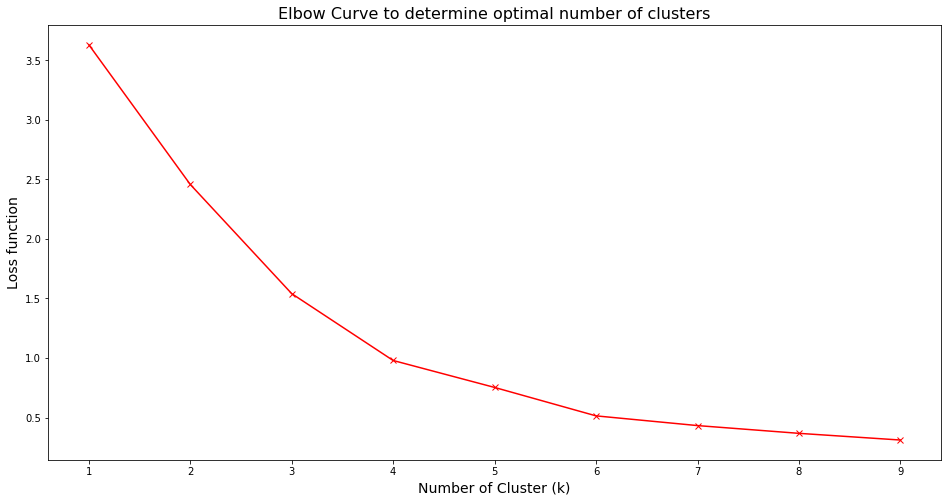

In [41]:
loss = []
k_values = np.arange(1,10)
for k in k_values:
    kmeans_model = KMeans(n_clusters= k, random_state= 10).fit(clustering_df_refined)
    loss.append(kmeans_model.inertia_)
plt.figure(figsize = (16,8))
plt.plot(k_values,loss, 'rx-')
plt.xlabel('Number of Cluster (k)', fontsize = 14)
plt.ylabel('Loss function', fontsize = 14)
plt.title('Elbow Curve to determine optimal number of clusters', fontsize = 16)
plt.show()

It is evident from the Elbow Curve that number of cluster `kclusters` beyond 4 has no significant reduction in Loss function

### 3.3 Clustering and adding cluster labels to `clustering_df` 

In [42]:
kclusters = 4
kmeans = KMeans(n_clusters= kclusters, random_state= 10).fit(clustering_df_refined)

In [43]:
cluster_labels = kmeans.labels_
clustering_df.insert(1, 'Cluster_labels', cluster_labels)

In [44]:
clustering_df.head()

,Neighborhood,Cluster_labels,Accessories Store,Asian Restaurant,Bar,Fast Food Restaurant,Gym / Fitness Center,Italian Restaurant,Movie Theater,Pizza Place,Warehouse Store
0,Cheranallur,0,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.200000,0.0
1,Cochin Special Economic Zone,3,0.000000,0.133333,0.000000,0.466667,0.133333,0.066667,0.000000,0.200000,0.0
2,Elamakkara,3,0.071429,0.071429,0.000000,0.571429,0.071429,0.000000,0.071429,0.142857,0.0
3,Ernakulam College,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
4,Ernakulam High Court,1,0.153846,0.153846,0.076923,0.230769,0.076923,0.000000,0.153846,0.153846,0.0


Eliminating East Calgary Facility from `clustering_df dataset`

In [45]:
ekm_clustered_df = clustering_df.drop(clustering_df.shape[0]-1)

## Step- 4. Preparing clustered dataset of Ernakulam 

#### Creating a dataset that includes cluster labels, neighborhood names and their geolocation data

In [46]:
ekm_neighborhood_df.head()

,Neighborhood,lat,lng
0,Amballur,10.4293,76.2914
1,Cheranallur,10.0608,76.2862
2,Chittor,10.4372,76.2079
3,Cochin Special Economic Zone,10.0042,76.3432
4,Edapally,18.7415,79.9697


In [47]:
clustering_merged = ekm_clustered_df.join(ekm_neighborhood_df.set_index('Neighborhood'), on = 'Neighborhood')
clustering_merged.head()

,Neighborhood,Cluster_labels,Accessories Store,Asian Restaurant,Bar,Fast Food Restaurant,Gym / Fitness Center,Italian Restaurant,Movie Theater,Pizza Place,Warehouse Store,lat,lng
0,Cheranallur,0,0.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.200000,0.0,10.0608,76.2862
1,Cochin Special Economic Zone,3,0.000000,0.133333,0.000000,0.466667,0.133333,0.066667,0.000000,0.200000,0.0,10.0042,76.3432
2,Elamakkara,3,0.071429,0.071429,0.000000,0.571429,0.071429,0.000000,0.071429,0.142857,0.0,10.0212,76.2949
3,Ernakulam College,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,10.0384,76.5074
4,Ernakulam High Court,1,0.153846,0.153846,0.076923,0.230769,0.076923,0.000000,0.153846,0.153846,0.0,9.98399,76.274


#### Visualizing clusters of Ernakulam

In [48]:
ekm_merged = clustering_merged.iloc[:, [0,1,-2,-1]]
ekm_merged.head()

,Neighborhood,Cluster_labels,lat,lng
0,Cheranallur,0,10.0608,76.2862
1,Cochin Special Economic Zone,3,10.0042,76.3432
2,Elamakkara,3,10.0212,76.2949
3,Ernakulam College,2,10.0384,76.5074
4,Ernakulam High Court,1,9.98399,76.274


In [49]:
# create map
map_clusters = folium.Map(location=[kochi_lat, kochi_long], zoom_start=12)

#adding Kochi city to map
folium.CircleMarker(
    [kochi_lat, kochi_long],
    popup = '<b>Kochi City</b>',
    radius = 15,
    fill = True,
    color = 'blue',
    fill_opacity = 0.3
).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.autumn(np.linspace(0, 1, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
# markers_colors = []
for lat, lon, poi, cluster in zip(ekm_merged['lat'], ekm_merged['lng'], ekm_merged['Neighborhood'], ekm_merged['Cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Step- 5. Filtering out Ernakulam's neighborhoods similar to that of East Calgary Facility 

#### Determine to which cluster does East Calgary Facility belongs to.

In [50]:
calgary_cluster_label = clustering_df[clustering_df.Neighborhood == 'East Calgary Facility']['Cluster_labels'].values[0]
calgary_cluster_label

1

East Calgary Facility belongs to second cluster with cluster label 1 as cluster labelling starts from 0. Lets find all the neighborhoods of Ernakulam are similar to East Calgary Facility.

In [51]:
kochi_facility_locs = ekm_merged[ekm_merged.Cluster_labels == calgary_cluster_label].reset_index(drop = True)
print('Number of suitable waste management facility locations for Kochi city is : ', kochi_facility_locs.shape[0]) #13
kochi_facility_locs.head(10)

Number of suitable waste management facility locations for Kochi city is :  16


,Neighborhood,Cluster_labels,lat,lng
0,Ernakulam High Court,1,9.98399,76.274
1,Ernakulam North,1,9.99166,76.2864
2,Kadavanthara,1,9.98026,76.2916
3,Kaloor,1,9.99502,76.2921
4,Kochi M.g.road,1,9.96428,76.2873
5,Kochi Palace,1,9.95835,76.2592
6,Mulavukad,1,10.011,76.2596
7,Palarivattom,1,10.0025,76.3062
8,Panampilly Nagar,1,9.96551,76.2943
9,Perumanur,1,9.94962,76.2936


#### Location of current waste management facility at Brahmapuram

In [52]:
kochi_waste_plant = 'Brahmapuram plant'
kochi_current_facility = geolocator.geocode(kochi_waste_plant)

#### Adding current waste management facility of Kochi City to cluster map

In [53]:
folium.Marker(
    [kochi_current_facility.latitude, kochi_current_facility.longitude],
    radius = 15,
    popup = '<b> Brahmapuram Facility</b>',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.3
).add_to(map_clusters)

map_clusters

## Conclusion

Lets see the total number of Ernakulam neighborhood we considered.

In [54]:
ekm_merged.shape[0]

32

And lets see the number of suitable neighborhoods of Ernakulam after clustering.

In [55]:
kochi_facility_locs.shape[0]

16

Even though 16 neighborhoods are similar to East Calgary Facility's neighborhood or vicinity, due to the present problems reported from Brahmapuram facility i.e nearness of waste management plant with 2 rivers that will result in a great social health catastrophe such as contamination of ground water utilized for drinking and risk of social epidemic, this study will further reduce the number of neighborhoods suitable for setting up a waste management plant. As it can be seen from the above map Palarivattom, Kaloor, Ernakulam North, Thammanam, Kadavanthara, Panampilly Nagar, Vyttila will be recommended as best possible options. The finalized locations are marked on the `best_location_map` as shown below.

In [76]:
best_locations = ['Palarivattom', 'Kaloor', 'Ernakulam North', 'Thammanam', 'Kadavanthara', 'Panampilly Nagar', 'Vyttila']
recommended_df = kochi_facility_locs.loc[kochi_facility_locs.Neighborhood.isin(best_locations),:].reset_index(drop = True)
recommended_df

,Neighborhood,Cluster_labels,lat,lng
0,Ernakulam North,1,9.99166,76.2864
1,Kadavanthara,1,9.98026,76.2916
2,Kaloor,1,9.99502,76.2921
3,Palarivattom,1,10.0025,76.3062
4,Panampilly Nagar,1,9.96551,76.2943
5,Thammanam,1,9.98329,76.2933
6,Vyttila,1,9.96611,76.3145


In [75]:
best_location_map = folium.Map(location=[kochi_lat, kochi_long], zoom_start = 12)

#adding Kochi city to map
folium.CircleMarker(
    [kochi_lat, kochi_long],
    popup = '<b>Kochi City</b>',
    radius = 15,
    fill = True,
    color = 'blue',
    fill_opacity = 0.6,
    fill_color = 'blue'
).add_to(best_location_map)

for lat, long, name, cluster_num in zip(recommended_df['lat'], recommended_df['lng'], recommended_df['Neighborhood'], recommended_df['Cluster_labels']):
    label = folium.Popup(name + ' Cluster ' + str(cluster_num))
    folium.CircleMarker(
    [lat, long],
    radius = 7,
    popup = label,
    fill = True,
    color = rainbow[0],
    fill_opacity = 0.7,
    fill_color = rainbow[0]
    ).add_to(best_location_map)
    
best_location_map

In [77]:
len(recommended_locs)

7

Thus, __out of 16 locations__ that turned up to be the best choices for setting up a new waste management plant, __only 7 of them are selected__ after the consideration of the drawbacks from Brahmapuram Facility, which is the present location of Kochi city's waste management plant. This analysis can be further improved if, government regulations and policies are to be taken into consideration, or if the differences in management practices between East Calgary Facility and Kochi City is studied. 